In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.cm

from scipy import sparse
import scipy.sparse.linalg

from collections import namedtuple
import sys
import zipfile
import wget
from io import StringIO
import itertools
import time
import json
import math

import gc

import scipy.linalg as sla
from scipy import spatial
from scipy.sparse.linalg import LinearOperator


from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn import metrics

import copy

import matplotlib as mpl
label_size = 15
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

#import gensim

import smtplib   
from email.mime.text import MIMEText

In [2]:
gc.collect()

0

In [3]:
def send_email(text):
    smtpObj = smtplib.SMTP('smtp.mail.ru', 587)
    smtpObj.starttls()
    smtpObj.login('yura603@mail.ru','Kolom7506')
    smtpObj.sendmail('yura603@mail.ru', 'yura603@mail.ru', text)

In [4]:
def tr_svd(A, k):
    U, S, Vh = scipy.sparse.linalg.svds(A, k)
    S = np.diag(S[::-1])
    U = U[:, ::-1]
    Vh = Vh[::-1,:]
    return U, S, Vh

    
class TermHSVD:

    def __init__(self, alpha):
        self.alpha = alpha

    def fit(self, R, S, n_components):
        self.n_samples = R.shape[0]
        self.n_features = R.shape[1]
        self.n_components = n_components
        self.S = S
        self.L_s = sla.cholesky(self.S * self.alpha + np.eye(self.n_features), lower=True)
        Op = LinearOperator(R.shape, matvec=lambda x : R.dot(self.L_s.dot(x)), 
                                    rmatvec=lambda x : self.L_s.T.dot(R.transpose().dot(x)))
        self.U, self.Sigma, self.VT = tr_svd(Op, n_components)

    def fit_transform(self, R, S, n_components):
        self.fit(R, S, n_components)
        return self.U @ self.Sigma

    def transform(self, r, n_components):
        u_sigma = r @ self.L_s @ self.VT[:n_components,:].T
        return u_sigma

    
def check_hybrid_SVD(X_train, X_test, y_train, y_test, S, components_list, 
                       clfs, alpha, folding_in_flag=True, str_adding=''):
    predictions_clfs = [[] for _ in clfs]
    max_components = max(components_list)
    term_hsvd = TermHSVD(alpha)
    print(str_adding + 'fitting Hybrid SVD')
    if folding_in_flag:
        term_hsvd.fit(X_train, S, max_components)
        U_train, Sigma, VT = term_hsvd.U, term_hsvd.Sigma, term_hsvd.VT
        U_test_Sigma = term_hsvd.transform(X_test, max_components)
    else:
        X = scipy.sparse.vstack([X_train, X_test])
        term_hsvd.fit(X, S, max_components)
        U, Sigma, VT = term_hsvd.U, term_hsvd.Sigma, term_hsvd.VT
        U_train = U[:X_train.shape[0]]
        U_test = U[X_train.shape[0]:]
        U_test_Sigma = U_test @ Sigma
    print(str_adding + 'fitting Hybrid SVD ended')
    U_train_Sigma = U_train @ Sigma
    for n_comps in components_list:
        print(str_adding + 'n_comps: %d' % n_comps)
        U_train_Sigma_cut = U_train_Sigma[:,:n_comps]
        U_test_Sigma_cut = U_test_Sigma[:,:n_comps]
        print(str_adding + 'fitting classifier number: ', end='')
        for clf_num, clf in enumerate(clfs):
            print(clf_num + 1, end=' ')
            clf.fit(U_train_Sigma_cut, y_train)
            predictions_clfs[clf_num].append(clf.predict(U_test_Sigma_cut))
        print('ended')
    print()
    return predictions_clfs


def check_ordinary_SVD(X_train, X_test, y_train, y_test, components_list, 
                       clfs, folding_in_flag=True, str_adding=''):
    predictions_clfs = [[] for _ in clfs]
    max_components = max(components_list)
    print(str_adding + 'fitting SVD')
    if folding_in_flag:
        U_train, Sigma, VT = tr_svd(X_train,  max_components)
        U_test_Sigma = X_test @ VT.T
    else:
        X = scipy.sparse.vstack([X_train.toarray(), X_test.toarray()])
        U, Sigma, VT = tr_svd(X,  max_components)
        U_train = U[:X_train.shape[0]]
        U_test = U[X_train.shape[0]:]
        U_test_Sigma = U_test @ Sigma
    U_train_Sigma = U_train @ Sigma
    print(str_adding + 'fitting SVD ended')
    for n_comps in components_list:
        print(str_adding + 'n_comps: %d' % n_comps)
        U_train_Sigma_cut = U_train_Sigma[:,:n_comps]
        U_test_Sigma_cut = U_test_Sigma[:,:n_comps]
        print(str_adding + 'fitting classifier number: ', end='')
        for clf_num, clf in enumerate(clfs):
            print(clf_num + 1, end=' ')
            clf.fit(U_train_Sigma_cut, y_train)
            predictions_clfs[clf_num].append(clf.predict(U_test_Sigma_cut))
        print('ended')
    print()
    return predictions_clfs


def compute_metrics(y_test, predictions, average='weighted'):
    avg_precisions = []
    avg_recalls = []
    avg_f1s = []
    avg_accuracies = []
    for predicted in predictions:
        avg_precision = metrics.classification.precision_score(y_test, predicted, average=average)
        avg_recall = metrics.classification.recall_score(y_test, predicted, average=average)
        avg_f1 = metrics.classification.f1_score(y_test, predicted, average=average)
        avg_accuracy = metrics.classification.accuracy_score(y_test, predicted)
        avg_precisions.append(avg_precision)
        avg_recalls.append(avg_recall)
        avg_f1s.append(avg_f1)
        avg_accuracies.append(avg_accuracy)
    return avg_precisions, avg_recalls, avg_f1s, avg_accuracies


def compute_metrics_baseline(y_test, predicted, average='weighted'):
    avg_precision = metrics.classification.precision_score(y_test, predicted, average=average)
    avg_recall = metrics.classification.recall_score(y_test, predicted, average=average)
    avg_f1 = metrics.classification.f1_score(y_test, predicted, average=average)
    avg_accuracy = metrics.classification.accuracy_score(y_test, predicted)
    return avg_precision, avg_recall, avg_f1, avg_accuracy

In [5]:
from joblib import Parallel, delayed

In [6]:
def check_one_fold(X_train, X_test, y_train, y_test, vocabulary, S, components_list,
                   alphas, clfs, cv_param=5, folding_in_flag=True, parallel_verbose=None):
    metrics_names = ['weighted', 'micro', 'macro']
    
    str_adding = ''
    if parallel_verbose is not None:
        str_adding = '(%s) ' % str(parallel_verbose)
    
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', token_pattern=r'(?u)\b[^\W\d][^\W\d]+\b', 
                                    vocabulary=vocabulary)
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    data = (X_train_tfidf, X_test_tfidf, y_train, y_test)
    #baseline
    baseline_predictions_clfs = []
    print(str_adding + 'baseline method:')
    print(str_adding + 'fitting classifier number: ', end='')
    for clf_num, clf in enumerate(clfs):
        print(clf_num + 1, end=' ')
        clf.fit(X_train_tfidf, y_train)
        baseline_predictions_clfs.append(clf.predict(X_test_tfidf))
    print('ended')
    metrics_baseline_clfs = [[] for _ in clfs]
    for clf_num, clf in enumerate(clfs):
        for metrics_name in metrics_names:
            metric_result = compute_metrics_baseline(y_test, 
                                baseline_predictions_clfs[clf_num], metrics_name)
            metrics_baseline_clfs[clf_num].append(metric_result)

    #svd
    svd_predictions_clfs = check_ordinary_SVD(*data, components_list, clfs, 
                                              folding_in_flag, str_adding)
    metrics_svd_clfs = [[] for _ in clfs]
    for clf_num, clf in enumerate(clfs):
        for metrics_name in metrics_names:
            metric_result = compute_metrics(y_test, 
                                svd_predictions_clfs[clf_num], metrics_name)
            metrics_svd_clfs[clf_num].append(metric_result)

    #hsvd
    results_hsvd = {}
    for alpha in alphas:
        hsvd_predictions_clfs = check_hybrid_SVD(*data, S, components_list, clfs, 
                                                 alpha, folding_in_flag, str_adding)
        metrics_hsvd_clfs = [[] for _ in clfs]
        for clf_num, clf in enumerate(clfs):
            for metrics_name in metrics_names:
                metric_result = compute_metrics(y_test, 
                                    hsvd_predictions_clfs[clf_num], metrics_name)
                metrics_hsvd_clfs[clf_num].append(metric_result)
        results_hsvd[alpha] = metrics_hsvd_clfs
    
    return (metrics_baseline_clfs, metrics_svd_clfs, results_hsvd)


def run_cv(X, target, vocabulary, S, components_list, alphas, clfs, cv_param=5, folding_in_flag=True):
    results = []
    kf = KFold(n_splits=cv_param)
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        print("split number: %d" % (i + 1))
        data = ([X[i] for i in train_index], [X[i] for i in test_index], target[train_index], target[test_index])
        one_fold_result = check_one_fold(*data, vocabulary, S, components_list,
                       alphas, clfs, cv_param, folding_in_flag)
        results.append(one_fold_result)
    return results


def run_cv_parallel(X, target, vocabulary, S, components_list, alphas, clfs, cv_param=5, 
                    folding_in_flag=True, parallel_verbose=True):
    results = []
    kf = KFold(n_splits=cv_param)
    results = Parallel(n_jobs=5)(delayed(check_one_fold)([X[i] for i in train_index], [X[i] for i in test_index], 
                                         target[train_index], target[test_index], 
                                         vocabulary, S, components_list,
                                           alphas, clfs, cv_param, folding_in_flag, i) \
                    for i, (train_index, test_index) in enumerate(kf.split(X)))
    return results

In [7]:
def compute_cv_average(avg_cv, interval=0.95):
    precisions = []
    recalls = []
    f1s = []
    for i in range(len(avg_cv)):
        precisions.append(avg_cv[i][0])
        recalls.append(avg_cv[i][1])
        f1s.append(avg_cv[i][2])
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    f1s = np.array(f1s)
    means = (precisions.mean(0), recalls.mean(0), f1s.mean(0))
    stds = (precisions.std(0), recalls.std(0), f1s.std(0))
    precision_interval = scipy.stats.t.interval(interval, len(precisions) - 1, loc=means[0],
                           scale=stds[0] / math.sqrt(len(precisions)))
    recall_interval = scipy.stats.t.interval(interval, len(recalls) - 1, loc=means[1],
                           scale=stds[1] / math.sqrt(len(recalls)))
    f1_interval = scipy.stats.t.interval(interval, len(f1s) - 1, loc=means[2],
                           scale=stds[2] / math.sqrt(len(f1s)))
    intervals = (precision_interval, recall_interval, f1_interval)
    return means, stds, intervals


def compute_hsvd_cv_average(results_hsvd_cv):
    res_means = {}
    res_stds = {}
    res_intervals = {}
    for alpha, val in results_hsvd_cv.items():
        res_means[alpha], res_stds[alpha], res_intervals[alpha] = compute_cv_average(val)
    return res_means, res_stds, res_intervals


def compute_svd_cv_average(avg_svd_cv):
    return compute_cv_average(avg_svd_cv)

In [8]:
def read_words(path, words_vocabulary):
    words_vectors = {}
    with open(path) as fastfile:
        for i, line in enumerate(fastfile):
            if i % 100000 == 0:
                print("line number: %d" % i)
            if i == 0:
                continue
            line_lst = line.strip().split()
            word = line_lst[0]
            if word in words_vocabulary:
                words_vectors[word] = list(map(float, line_lst[1:]))
            #if i > max_line_number:
            #    break
    res_vocabulary = []
    res = []
    for word in words_vocabulary:
        if words_vectors.get(word) is not None:
            res.append(words_vectors[word])
            res_vocabulary.append(word)
    return np.array(res), res_vocabulary


def compute_word_vectors(data, vocab_size, word_vectors_path,
                        vocabulary_path_template, word_vectors_path_template):
    vectorizer = TfidfVectorizer(stop_words='english', token_pattern=r'(?u)\b[^\W\d][^\W\d]+\b', 
                                             max_features=vocab_size)
    vectorizer.fit(data['x_train'])
    word_vectors, vocabulary = read_words(word_vectors_path, vectorizer.get_feature_names())

    with open(vocabulary_path_template % vocab_size, 'w') as f:
        for x in vocabulary:
            f.write('%s\n' % x)
    np.save(word_vectors_path_template % vocab_size, word_vectors)
    return word_vectors, vocabulary


def load_word_vectors(vocab_size, vocabulary_path_template, 
                      word_vectors_path_template):
    with open(vocabulary_path_template % vocab_size) as f:
        vocabulary = [x.strip() for x in f]
    word_vectors = np.load(word_vectors_path_template % vocab_size)
    return word_vectors, vocabulary

In [9]:
categories = None
twenty_train = fetch_20newsgroups(subset='train',
                categories=categories, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
twenty_test = fetch_20newsgroups(subset='test',
                    categories=categories, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
data = {
    'x_train': twenty_train['data'],
    'x_test': twenty_test['data'],
    'y_train': twenty_train['target'],
    'y_test': twenty_test['target']
}

In [10]:
vocab_size = 8000

In [11]:
word_vectors_path = '/root/word_vectors/wiki-news-300d-1M.vec'
vocabulary_path_template = '/root/hlsi/fast_20news/vocabulary_%d.txt'
word_vectors_path_template = '/root/hlsi/fast_20news/word_vectors_%d.npy'

In [12]:
word_vectors, vocabulary = load_word_vectors(vocab_size, vocabulary_path_template, 
                                              word_vectors_path_template)
#compute_word_vectors(data, vocab_size, word_vectors_path,
#                                                vocabulary_path_template, word_vectors_path_template)

In [13]:
words_dist = spatial.distance.cdist(word_vectors, word_vectors, metric='cosine')
words_similarities = np.ones(words_dist.shape) - words_dist
S = words_similarities - np.identity(words_dist.shape[0])

In [14]:
alphas = [0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 0.9]
components_list = np.hstack([np.arange(3, 20, 5), 
                             np.arange(20, 100, 10), 
                             np.arange(100, 1001, 100)])

In [15]:
penalty_params = np.array([0.01, 0.1, 0.5, 1, 10])

In [16]:
clfs = [LinearSVC(C=C, random_state=66) for C in penalty_params]

In [18]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', token_pattern=r'(?u)\b[^\W\d][^\W\d]+\b', 
                                    vocabulary=vocabulary)
X_train_tfidf = tfidf_vectorizer.fit_transform(data['x_train'])
X_test_tfidf = tfidf_vectorizer.transform(data['x_test'])

In [19]:
y_train = data['y_train']
y_test = data['y_test']

###  Local

In [ ]:
def fit_predict_class_c_local(X_train, y_train, X_test, class_c, n_comp, real_clf, alpha):
    #print (class_c, '\n')
    str_adding = str(class_c)
    space_indices = np.where(y_train == class_c)[0]
    non_space_indices = np.where(y_train != class_c)[0]
    y_train_transformed = np.zeros_like(y_train)
    y_train_transformed[space_indices] = 1
    X_1 = X_train[space_indices]
    #print (X_1.shape)
    X_2 = X_train[non_space_indices]
    y_1 = y_train_transformed[space_indices]
    y_2 = y_train_transformed[non_space_indices]
    
    if (n_comp > min(X_1.shape)):
        n_comp = min(X_1.shape)-1

    #u,s,vh = tr_svd(X_1, n_comp)
    
    print(str_adding + ' fitting Hybrid SVD with n_comp:', n_comp)
    t0 = time.time()
    term_hsvd = TermHSVD(alpha)
    term_hsvd.fit(X_1, S, n_comp)
    print(str_adding + ' ended, time passed:', time.time() - t0)
    
    U_train, Sigma, VT = term_hsvd.U, term_hsvd.Sigma, term_hsvd.VT
    
    X_1_transformed = U_train @ Sigma
    X_2_transformed = term_hsvd.transform(X_2, n_comp)
    X_test_transformed = term_hsvd.transform(X_test, n_comp)
    
    X = np.vstack((X_1_transformed, X_2_transformed))
    y = np.hstack((y_1, y_2))

    print(str_adding + ' fitting  real clf\n')
    t0 = time.time()
    real_clf.fit(X, y)
    print(str_adding + '  real clf ended, time passed:', time.time() - t0)
    decisions = real_clf.decision_function(X_test_transformed)
    return decisions

#def dec_append(decisions,X_train, y_train,X_test,class_c,
                           #                  n_comp,initial_clf, real_clf, a,b,gamma_size):
    #decisions[class_c] = fit_predict_class_c_local(X_train, y_train,X_test,class_c,
                                            # n_comp,initial_clf, real_clf, a,b)

def fit_predict_local(X_train, y_train, X_test, n_comp, real_clf, alpha):
    n_classes = max(y_train) + 1
    decisions = []

    decisions = Parallel(n_jobs=4)(delayed(fit_predict_class_c_local)\
                                   (X_train, y_train, X_test, class_c=i,
                                     n_comp=n_comp, real_clf=real_clf, alpha=alpha)
                                   for i in range(n_classes))
    
    #for i in range(n_classes):
    #    decisions.append(fit_predict_class_c_local(X_train, y_train, X_test, class_c=i,
    #                                        n_comp=n_comp, real_clf=real_clf, alpha=alpha))
    decisions = np.vstack(decisions)
    pred = decisions.argmax(axis=0) 
    return pred

In [ ]:
components_list_final = [3, 8, 13, 20, 50, 100, 200, 300, 500, 700, 1000]
c = 0.1
real_clf = LinearSVC(C = c)

In [ ]:
def Compute_Local_RDS_full(X_train, X_test, y_train, n_comp, alpha, real_clf):
    t0 = time.time()
    pred = fit_predict_local(X_train, y_train, X_test, n_comp, real_clf, alpha)
    print (n_comp, 'time passed: ', time.time() - t0,'\n')
    return pred

In [136]:
components_list_final = [8, 50, 100, 300, 500]
alpha = 0.1

In [137]:
len(components_list_final)

5

In [139]:
real_clfs = [LinearSVC(C = c) for c in [10, 5, 1, 0.1, 0.1]]

results_RDS_full = []
for real_clf, n_comp in zip(real_clfs, components_list_final):
    print('computing component: %d' % n_comp)
    res = Compute_Local_RDS_full(X_train_tfidf, X_test_tfidf, y_train, n_comp, alpha, real_clf)
    results_RDS_full.append(res)

In [ ]:
send_email('Local_Hybrid_collaboration ended2')

In [142]:
def compute_local_metrics(results_RDS_full, components_list_final):
    results_final =[]
    f1_scores =[]
    precisions = []
    recalls =[]
    accuracies = []
    for n in range(len(components_list_final)):
        pred = results_RDS_full[n]
        f1_scores.append(metrics.f1_score(twenty_test.target, pred, average='weighted'))
        precisions.append(metrics.precision_score(twenty_test.target, pred, average='weighted'))
        recalls.append(metrics.recall_score(twenty_test.target, pred, average='weighted'))
        accuracies.append(metrics.accuracy_score(twenty_test.target, pred))
    results_final.append(f1_scores)
    results_final.append(precisions)
    results_final.append(recalls)
    results_final.append(accuracies)
    return results_final

In [143]:
results_final_rds = compute_local_metrics(results_RDS_full, components_list_final)

In [144]:
results_final_rds[0]

[0.50187714524699878,
 0.58903744331924002,
 0.60702436727407694,
 0.62210470734671297,
 0.62954050315007826]

In [146]:
components_list_final

[8, 50, 100, 300, 500]

In [151]:
results_final_rds_old = [ 0.57740596,  0.59908695,  0.60087816,  0.61619641,  0.62651445]

In [159]:
def plot_3_arrays(x, y1, y2, y3, metric_index=0, figsize=(8, 6), title=''):
    plt.figure(figsize=figsize)
    #y1 = [x[metric_index] for x in ys1]
    #y2 = [x[metric_index] for x in ys2]
    plt.plot(x, y1, label='Local+Hybrid LSI')
    plt.plot(x, y2, label='Local LSI')
    
    plt.plot(x, y3, label='LRW LSI')
    
    plt.title(title, size=22)
    plt.legend(prop={'size': 14}, loc="lower right")
    plt.grid(color='lightgray', linestyle='dashed')
    plt.show()
    
    
def plot_2_arrays(x, y1, y2, metric_index=0, figsize=(8, 6), title='',save_path=None):
    plt.figure(figsize=figsize)
    #y1 = [x[metric_index] for x in ys1]
    #y2 = [x[metric_index] for x in ys2]
    plt.plot(x, y1, label='Local+Hybrid LSI', lw=3)
    plt.plot(x, y2, label='Local LSI', lw=3)
        
    plt.title(title, size=22)
    plt.legend(prop={'size': 14}, loc="lower right")
    plt.grid(color='lightgray', linestyle='dashed')
    plt.xlabel('Number of components', size=15)
    plt.ylabel('Weighted F1', size=15)
    
    if save_path is not None:
        plt.savefig(save_path + ".eps", bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [196]:
res_weighted = [ 0.60800953,  0.63171379,  0.63847427,  0.6420128 ,  0.64728331]

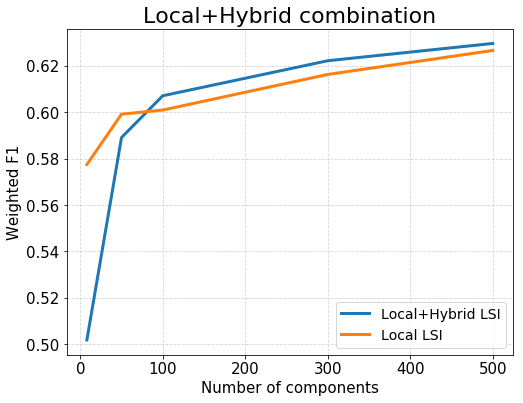

In [197]:
plot_2_arrays(components_list_final, results_final_rds[0], results_final_rds_old, 
              res_weighted, title='Local+Hybrid combination')

In [161]:
plot_2_arrays(components_list_final, results_final_rds[0], results_final_rds_old, 
              res_weighted, title='Local+Hybrid combination', save_path='local_hybrid')

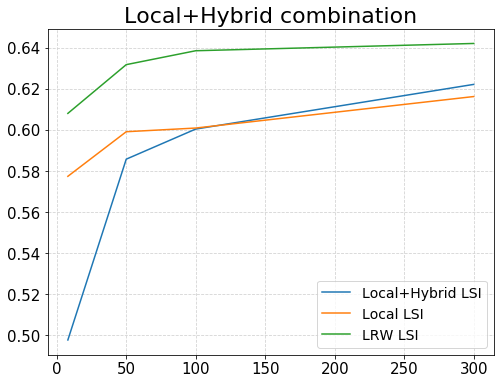

In [122]:
plot_3_arrays(components_list_final, results_final_rds[0], results_final_rds_old, 
              res_weighted, title='Local+Hybrid combination')

In [184]:
def f(rs, a,b):
    return 1/(1+np.exp(-a*(rs+b)))

def fit_predict_class_c(X_train, y_train, X_test, alpha, class_c, n_comp, initial_clf, 
                        real_clf, a=2, b=0.1, gamma_size = 1.5):
    #print (class_c, '\n')
    str_adding = str(class_c)
    indices = np.where(y_train == class_c)[0]
    n = int(len(indices)*gamma_size)
    y_train_transformed = np.zeros_like(y_train)
    y_train_transformed[indices] = 1
    
    #print ("Fitiing\n")
    initial_clf.fit(X_train,y_train_transformed)
    #print ('Fitted\n')
    initial_relevancy = initial_clf.decision_function(X_train)
    relevancy =  f(initial_relevancy,a,b)
    X_train = (X_train.T @ scipy.sparse.csr_matrix(np.diag(relevancy))).T
    
    #X_train = (X_train.T@np.diag(relevancy)).T
    space_indices = relevancy.argsort()[-n:][::-1]
    #print (space_indices.shape)
    non_space_indices = relevancy.argsort()[:-n][::-1]
    X_1 = X_train[space_indices]
    #print (X_1.shape)
    X_2 = X_train[non_space_indices]
    y_1 = y_train_transformed[space_indices]
    y_2 = y_train_transformed[non_space_indices]
    #print ('TrSVD\n')
    if (n_comp > min(X_1.shape)):
        n_comp = min(X_1.shape)-1

    #u,s,vh = tr_svd(X_1, n_comp)
    
    print(str_adding + ' fitting Hybrid SVD with n_comp:', n_comp)
    t0 = time.time()
    term_hsvd = TermHSVD(alpha)
    term_hsvd.fit(X_1, S, n_comp)
    print(str_adding + ' ended, time passed:', time.time() - t0)
    
    U_train, Sigma, VT = term_hsvd.U, term_hsvd.Sigma, term_hsvd.VT
    
    X_1_transformed = U_train @ Sigma
    X_2_transformed = term_hsvd.transform(X_2, n_comp)
    
    rel_for_test = f(initial_clf.predict(X_test), a, b)
    X_test = (X_test.T @ np.diag(rel_for_test)).T
    X_test_transformed = term_hsvd.transform(X_test, n_comp)
    
    X = np.vstack((X_1_transformed, X_2_transformed))
    y = np.hstack((y_1, y_2))
    
    print(str_adding + ' fitting  real clf\n')
    real_clf.fit(X, y)
    print(str_adding + '  real clf ended, time passed:', time.time() - t0)
    decisions = real_clf.decision_function(X_test_transformed)
    return decisions


def fit_predict(X_train, y_train, X_test, n_comp, alpha, initial_clf, real_clf, a,b,gamma_size):
    n_classes = max(y_train) + 1
    decisions = []

    decisions = Parallel(n_jobs=4)(delayed(fit_predict_class_c)\
                                   (X_train, y_train, X_test, alpha, i,
                                     n_comp, initial_clf, real_clf, a, b, gamma_size)
                                   for i in range(n_classes))
    
    #for i in range(n_classes):
    #    decisions.append(fit_predict_class_c_local(X_train, y_train, X_test, class_c=i,
    #                                        n_comp=n_comp, real_clf=real_clf, alpha=alpha))
    decisions = np.vstack(decisions)
    pred = decisions.argmax(axis=0) 
    return pred

In [182]:
def Compute_Local_Weighted_full(X_train, X_test, y_train, n_comp, alpha, initial_clf, real_clf, a, b, gamma):
    t0 = time.time()
    pred = fit_predict(X_train, y_train, X_test, n_comp, alpha, initial_clf, real_clf, a, b, gamma)
    print (n_comp, 'time passed: ', time.time() - t0,'\n')
    return pred

In [173]:
initial_clf = LinearSVC(C=0.1)

In [174]:
c

0.1

In [175]:
real_clf = LinearSVC(C = c)

In [176]:
a = 5
b = 0.8
gamma = 2

In [177]:
alpha

0.1

In [178]:
real_clfs = [LinearSVC(C = c) for c in [10, 5, 1, 0.1, 0.1]]

In [189]:
components_list_final

[8, 50, 100, 300, 500]

In [ ]:
results_weighted_full = []
for real_clf, n_comp in zip(real_clfs, components_list_final):
    print('computing component: %d' % n_comp)
    res = Compute_Local_Weighted_full(X_train_tfidf, X_test_tfidf, y_train, n_comp, alpha, 
                                      initial_clf, real_clf, a, b, gamma)
    results_weighted_full.append(res)

computing component: 8
1 fitting Hybrid SVD with n_comp: 8
2 fitting Hybrid SVD with n_comp: 8
3 fitting Hybrid SVD with n_comp: 8
0 fitting Hybrid SVD with n_comp: 8
2 ended, time passed: 6.649643182754517
0 ended, time passed: 6.403778791427612
3 ended, time passed: 6.884170055389404
1 ended, time passed: 7.06086277961731
0 fitting  real clf

1 fitting  real clf

2 fitting  real clf

1  real clf ended, time passed: 21.31731867790222
0  real clf ended, time passed: 20.97161602973938
2  real clf ended, time passed: 21.80265736579895
3 fitting  real clf

3  real clf ended, time passed: 22.838778257369995
4 fitting Hybrid SVD with n_comp: 8
6 fitting Hybrid SVD with n_comp: 8
5 fitting Hybrid SVD with n_comp: 8
7 fitting Hybrid SVD with n_comp: 8
4 ended, time passed: 5.086724758148193
6 ended, time passed: 5.907441139221191
5 ended, time passed: 6.662567377090454
7 ended, time passed: 6.668015956878662
4 fitting  real clf

5 fitting  real clf

5  real clf ended, time passed: 20.07333970

14 ended, time passed: 28.34906506538391
15 ended, time passed: 26.763823986053467
12 fitting  real clf

12  real clf ended, time passed: 43.12786674499512
16 fitting Hybrid SVD with n_comp: 100
13 fitting  real clf

13  real clf ended, time passed: 46.424524545669556
14 fitting  real clf

14  real clf ended, time passed: 43.15135741233826
15 fitting  real clf

17 fitting Hybrid SVD with n_comp: 100
15  real clf ended, time passed: 41.908621072769165
18 fitting Hybrid SVD with n_comp: 100
19 fitting Hybrid SVD with n_comp: 100
16 ended, time passed: 32.55064511299133
17 ended, time passed: 27.880517721176147
18 ended, time passed: 29.4488742351532
19 ended, time passed: 27.87041997909546
16 fitting  real clf

16  real clf ended, time passed: 46.80275011062622
17 fitting  real clf

17  real clf ended, time passed: 42.5819616317749
18 fitting  real clf

19 fitting  real clf

18  real clf ended, time passed: 43.568145990371704
19  real clf ended, time passed: 41.634992361068726
100 time p

In [ ]:
send_email('Local_Hybrid_collaboration lrw ended')

In [191]:
results_final_lrw = compute_local_metrics(results_weighted_full, components_list_final)
results_final_lrw2 = compute_local_metrics(results_weighted_full2, components_list_final)

In [229]:
X_test_tfidf.shape

(7532, 7629)

In [216]:
results_weighted_full3 = []
for real_clf, n_comp in zip(real_clfs, components_list_final):
    print('computing component: %d' % n_comp)
    res = Compute_Local_Weighted_full(X_train_tfidf, X_test_tfidf, y_train, n_comp, 0.5, 
                                      initial_clf, real_clf, a, b, gamma)
    results_weighted_full3.append(res)

computing component: 8
0 fitting Hybrid SVD with n_comp: 8
1 fitting Hybrid SVD with n_comp: 8
2 fitting Hybrid SVD with n_comp: 8
3 fitting Hybrid SVD with n_comp: 8
2 ended, time passed: 5.2378222942352295
1 ended, time passed: 5.605532884597778
0 ended, time passed: 5.813312292098999
3 ended, time passed: 5.854200601577759
3 fitting  real clf

2 fitting  real clf

3  real clf ended, time passed: 17.436490535736084
1 fitting  real clf

2  real clf ended, time passed: 17.957205533981323
1  real clf ended, time passed: 18.249205350875854
4 fitting Hybrid SVD with n_comp: 8
6 fitting Hybrid SVD with n_comp: 8
5 fitting Hybrid SVD with n_comp: 8
0 fitting  real clf

0  real clf ended, time passed: 22.07397484779358
6 ended, time passed: 4.524049758911133
4 ended, time passed: 5.065029144287109
5 ended, time passed: 4.374032497406006
7 fitting Hybrid SVD with n_comp: 8
7 ended, time passed: 2.7528655529022217
6 fitting  real clf

6  real clf ended, time passed: 16.740803003311157
4 fittin

15 ended, time passed: 25.187920093536377
14 ended, time passed: 26.79757809638977
12 fitting  real clf

12  real clf ended, time passed: 40.89752793312073
13 fitting  real clf

13  real clf ended, time passed: 41.684449434280396
15 fitting  real clf

16 fitting Hybrid SVD with n_comp: 100
14 fitting  real clf

15  real clf ended, time passed: 40.17696571350098
14  real clf ended, time passed: 41.426389932632446
17 fitting Hybrid SVD with n_comp: 100
18 fitting Hybrid SVD with n_comp: 100
19 fitting Hybrid SVD with n_comp: 100
17 ended, time passed: 25.19871687889099
18 ended, time passed: 24.65886926651001
16 ended, time passed: 27.107807636260986
19 ended, time passed: 24.943081855773926
17 fitting  real clf

18 fitting  real clf

16 fitting  real clf

17  real clf ended, time passed: 40.49047374725342
16  real clf ended, time passed: 41.63029742240906
18  real clf ended, time passed: 40.08071684837341
19 fitting  real clf

19  real clf ended, time passed: 40.12387752532959
100 time 

In [217]:
send_email('Local_Hybrid_collaboration lrw ended 0.5')

In [218]:
results_weighted_full4 = []
for real_clf, n_comp in zip(real_clfs, components_list_final):
    print('computing component: %d' % n_comp)
    res = Compute_Local_Weighted_full(X_train_tfidf, X_test_tfidf, y_train, n_comp, 0.7, 
                                      initial_clf, real_clf, a, b, gamma)
    results_weighted_full4.append(res)

computing component: 8
2 fitting Hybrid SVD with n_comp: 8
3 fitting Hybrid SVD with n_comp: 8
0 fitting Hybrid SVD with n_comp: 8
1 fitting Hybrid SVD with n_comp: 8
2 ended, time passed: 5.844026565551758
0 ended, time passed: 6.079580068588257
3 ended, time passed: 6.467095375061035
1 ended, time passed: 6.464448690414429
2 fitting  real clf

1 fitting  real clf

3 fitting  real clf

2  real clf ended, time passed: 20.92505192756653
1  real clf ended, time passed: 20.952026844024658
3  real clf ended, time passed: 21.546008825302124
0 fitting  real clf

4 fitting Hybrid SVD with n_comp: 8
0  real clf ended, time passed: 22.41710901260376
5 fitting Hybrid SVD with n_comp: 8
6 fitting Hybrid SVD with n_comp: 8
7 fitting Hybrid SVD with n_comp: 8
4 ended, time passed: 4.209593296051025
5 ended, time passed: 5.111647367477417
6 ended, time passed: 5.440096855163574
7 ended, time passed: 5.2142720222473145
6 fitting  real clf

4 fitting  real clf

6  real clf ended, time passed: 18.21822

14 ended, time passed: 25.68340277671814
15 ended, time passed: 21.28315830230713
13 fitting  real clf

14 fitting  real clf

12 fitting  real clf

13  real clf ended, time passed: 41.06190037727356
14  real clf ended, time passed: 40.83861017227173
12  real clf ended, time passed: 42.183640480041504
16 fitting Hybrid SVD with n_comp: 100
17 fitting Hybrid SVD with n_comp: 100
18 fitting Hybrid SVD with n_comp: 100
15 fitting  real clf

15  real clf ended, time passed: 40.66311168670654
19 fitting Hybrid SVD with n_comp: 100
17 ended, time passed: 20.947396755218506
16 ended, time passed: 22.969858646392822
18 ended, time passed: 24.682889461517334
19 ended, time passed: 19.258085012435913
16 fitting  real clf

17 fitting  real clf

17  real clf ended, time passed: 38.772440671920776
18 fitting  real clf

16  real clf ended, time passed: 40.12618041038513
18  real clf ended, time passed: 39.73067593574524
19 fitting  real clf

19  real clf ended, time passed: 31.944040060043335
100 tim

In [219]:
send_email('Local_Hybrid_collaboration lrw ended 0.7')

In [222]:
results_final_lrw3 = compute_local_metrics(results_weighted_full3, components_list_final)
results_final_lrw4 = compute_local_metrics(results_weighted_full4, components_list_final)

/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [223]:
results_final_lrw_alphas = {'0.1': results_final_lrw[0], '0.2': results_final_lrw2[0],
                           '0.5': results_final_lrw3[0], '0.7': results_final_lrw4[0]}

In [224]:
def plot_comparison(x, local, local_hybrid, lrw, lrw_hybrid, alphas,
                   figsize=(8, 6), title='',save_path=None):
    plt.figure(figsize=figsize)
    #y1 = [x[metric_index] for x in ys1]
    #y2 = [x[metric_index] for x in ys2]
    plt.plot(x, local, label='Local LSI', lw=3)
    plt.plot(x, local_hybrid, label='Local+Hybrid LSI', lw=3)
    
    plt.plot(x, lrw, label='LRW LSI', lw=3)
    for alpha in alphas:
        plt.plot(x, lrw_hybrid[alpha], label='LRW+Hybrid LSI, $\\alpha=%s$' % str(alpha), lw=3)

    plt.title(title, size=22)
    plt.legend(prop={'size': 14}, loc="lower right")
    plt.grid(color='lightgray', linestyle='dashed')
    plt.xlabel('Number of components', size=15)
    plt.ylabel('Weighted F1', size=15)
    
    if save_path is not None:
        plt.savefig(save_path + ".eps", bbox_inches='tight')
        plt.close()
    else:
        plt.show()

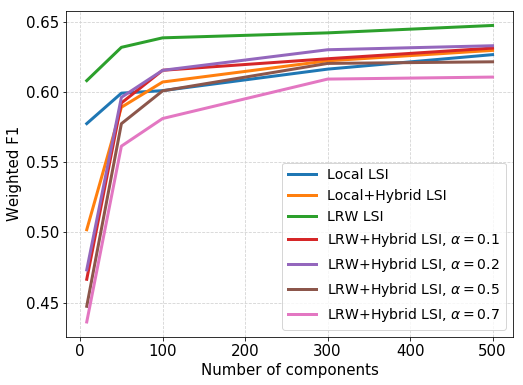

In [227]:
plot_comparison(components_list_final, results_final_rds_old, results_final_rds[0],
                res_weighted, results_final_lrw_alphas, ['0.1', '0.2', '0.5', '0.7'])